In [1]:
from project.models.lit_modules import SeqAnnotator
from project.dataset.lit_module import SeqAnnotationDM
import numpy as np

In [2]:
dm = SeqAnnotationDM(
    "data/games_0001/train_100K.parquet",
    "data/games_0001/val_100K.parquet",
    "data/games_0001/test_100K.parquet",
    32,
    ["Moves"],
    ["pieces"],
    8,
)
dm.setup()
ds = dm.test_set
model = SeqAnnotator.load_from_checkpoint(
    "checkpoints/pieces/lstm-best.ckpt", label="pieces")

Loading parquet file @  data/games_0001/train_100K.parquet  with columns  ['Moves', 'pieces']
Loaded 70000 rows and 2 columns


Converting columns to indices: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


Loading parquet file @  data/games_0001/val_100K.parquet  with columns  ['Moves', 'pieces']
Loaded 19999 rows and 2 columns


Converting columns to indices: 100%|██████████| 2/2 [00:00<00:00,  5.52it/s]


Loading parquet file @  data/games_0001/test_100K.parquet  with columns  ['Moves', 'pieces']
Loaded 10001 rows and 2 columns


Converting columns to indices: 100%|██████████| 2/2 [00:00<00:00, 10.95it/s]


In [3]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
out = []
with torch.no_grad():
    for inp, _ in tqdm(ds):
        inp = inp[0]
        res, _ = model.forward(inp.cuda())
        out.append(res)

100%|██████████| 10001/10001 [00:58<00:00, 171.67it/s]


100%|██████████| 10001/10001 [00:00<00:00, 34606.62it/s]


Text(0, 0.5, 'Entropy base 2')

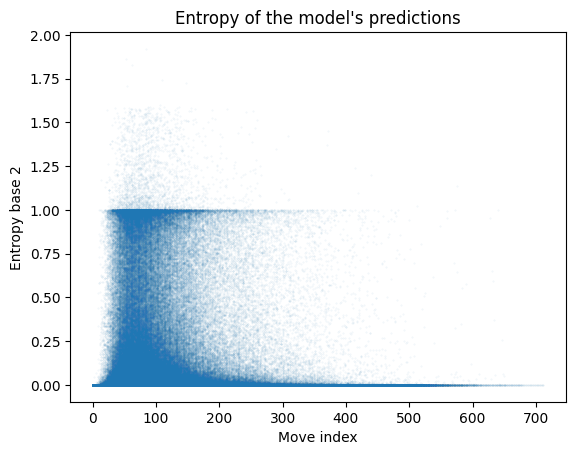

In [12]:
def entropy(x):
    return -np.sum(x * np.log2(x + 1e-10), axis=-1)


entropies = []
indices = []
for i in tqdm(out):
    entropies.append(entropy(i.cpu().numpy()))
    indices.append(np.arange(len(i)))

plt.scatter(
    np.concatenate(indices),
    np.concatenate(entropies),
    alpha=0.1,
    s=0.1,
)
plt.title("Entropy of the model's predictions")
plt.xlabel("Move index")
plt.ylabel("Entropy base 2")

100%|██████████| 10001/10001 [00:00<00:00, 21708.37it/s]


Text(0, 0.5, 'Entropy base 2')

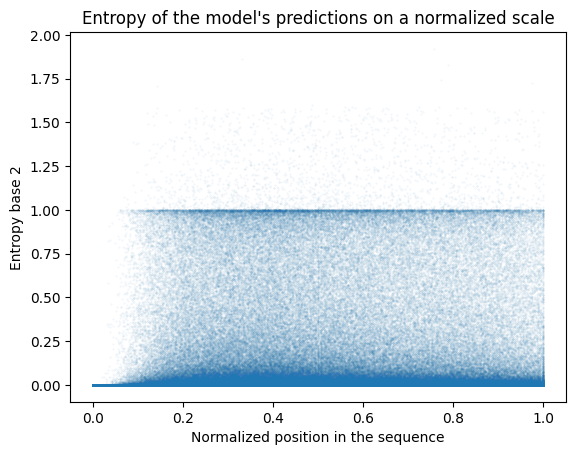

In [11]:
entropies = []
indices = []
for i in tqdm(out):
    entropies.append(entropy(i.cpu().numpy()))
    indices.append(np.linspace(0, 1, len(i)))

plt.scatter(
    np.concatenate(indices),
    np.concatenate(entropies),
    alpha=0.1,
    s=0.1,
)
plt.title("Entropy of the model's predictions on a normalized scale")
plt.xlabel("Normalized position in the sequence")
plt.ylabel("Entropy base 2")

In [ ]:
bins = np.linspace(0, 1, 100)
means = np.zeros(len(bins))
stds = np.zeros(len(bins))
for i in tqdm(out):
    seq_bins = bins * len(i)
    bin_idx = np.digitize(np.arange(len(i)), seq_bins)
    for j in range(1, len(bins)):
        e = entropy(i[bin_idx == j].numpy()).mean()
        means[j] += e.mean()
        stds[j] += e.std()

means /= len(out)
stds /= len(out)

  0%|          | 17/10001 [00:00<01:00, 165.76it/s]/tmp/ipykernel_151443/777786918.py:14: RuntimeWarning: Mean of empty slice.
  e = entropy(i[bin_idx == j].numpy()).mean()
/home/airlab/miniconda3/envs/nlp/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 10001/10001 [00:51<00:00, 193.76it/s]
